In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl
from gwpy.timeseries import TimeSeries
import math
import random
from matplotlib.lines import Line2D

from scipy import integrate

In [2]:
epochs = 400
test_sample_ratio = .2
validation_sample_ratio = 0.1
batch_size = 32
coef_delta = 0

In [3]:
TPR_list_for_plot = np.zeros((0,30))

## Setting global functions

### Usual AE model

In [76]:
class AutoEncoder(nn.Module):
    def __init__(self, feature_space, latent_space):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(feature_space, 3),
            nn.ReLU(),
            nn.Linear(3, latent_space),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_space, 3),
            nn.ReLU(),
            nn.Linear(3, feature_space),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

### New VAE model

In [3]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, feature_space, latent_space):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(feature_space, 3),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(3, latent_space)  # 均值
        self.fc_logvar = nn.Linear(3, latent_space)  # 方差
        self.decoder = nn.Sequential(
            nn.Linear(latent_space, 3),
            nn.ReLU(),
            nn.Linear(3, feature_space),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return mu, logvar, z, decoded

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

### Weakly Supervised Learning DNN

In [17]:
class SupervisedModel(nn.Module):
    def __init__(self):
        super(SupervisedModel, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 6)
        self.fc3 = nn.Linear(6, 4)
        self.fc4 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

### WSL 5-8-6-4-1

In [ ]:
class SupervisedModel(nn.Module):
    def __init__(self):
        super(SupervisedModel, self).__init__()
        self.fc1 = nn.Linear(5, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 6)
        self.fc3 = nn.Linear(6, 4)
        self.fc4 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

## Introducing the data to use

In [3]:
Reconstruction_error_L = np.load('../Data_cached/Reconstruction_error_GWAKset_L_1.npz')
Reconstruction_error_H = np.load('../Data_cached/Reconstruction_error_GWAKset_H_1.npz')

In [6]:
Pearson_correlation_noise = np.load('../Data_cached/Pearson_GWAK_BKG.npy')

In [7]:
Pearson_correlation_bbh = np.load('../Data_cached/Pearson_GWAK_BBH.npy')

In [8]:
Pearson_correlation_sg = np.load('../Data_cached/Pearson_GWAK_SG.npy')

In [7]:
Reconstruction_error_noise = np.load('../Data_cached/Normalized_error_data_for_MultiAE.npz')['noise_error']
Reconstruction_error_glitch = np.load('../Data_cached/Normalized_error_data_for_MultiAE.npz')['glitch_error']
Reconstruction_error_bbh = np.load('../Data_cached/Normalized_error_data_for_MultiAE.npz')['bbh_error']
Reconstruction_error_sg = np.load('../Data_cached/Normalized_error_data_for_MultiAE.npz')['sg_error']

## Package the data

In [9]:
Reconstruction_error_L.keys()

KeysView(NpzFile '../Data_cached/Reconstruction_error_GWAKset_L.npz' with keys: noise_train_pattern, noise_train_norm, noise_test_pattern, noise_test_norm, bbh_pattern...)

In [10]:
Reconstruction_error_L['noise_train_pattern'].shape

(70000,)

In [18]:
Pearson_correlation_noise

array([0.26787238, 0.29201685, 0.25758892, ..., 0.25960671,
       0.25876541, 0.20161902])

In [4]:
Feature_space_noise_train = np.vstack((Reconstruction_error_L['noise_train_pattern'],Reconstruction_error_H['noise_train_pattern'])).T
Feature_space_noise_test = np.vstack((Reconstruction_error_L['noise_test_pattern'],Reconstruction_error_H['noise_test_pattern'])).T
Feature_space_bbh = np.vstack((Reconstruction_error_L['bbh_pattern'],Reconstruction_error_H['bbh_pattern'])).T
Feature_space_sg = np.vstack((Reconstruction_error_L['sg_pattern'],Reconstruction_error_H['sg_pattern'])).T

In [16]:
Feature_space_noise_train = np.vstack((Reconstruction_error_L['noise_train_pattern'], Reconstruction_error_L['noise_train_norm'], Reconstruction_error_H['noise_train_pattern'], Reconstruction_error_H['noise_train_norm'], Pearson_correlation_noise[0:int((1-test_sample_ratio-validation_sample_ratio) * len(Pearson_correlation_noise))])).T

In [79]:
Feature_space_noise_train = np.vstack((Reconstruction_error_L['noise_train_pattern'], Reconstruction_error_L['noise_train_norm'], Reconstruction_error_H['noise_train_pattern'], Reconstruction_error_H['noise_train_norm'])).T

In [6]:
Feature_space_noise_train.shape

(70000, 4)

In [21]:
Feature_space_noise_test = np.vstack((Reconstruction_error_L['noise_test_pattern'], Reconstruction_error_L['noise_test_norm'], Reconstruction_error_H['noise_test_pattern'], Reconstruction_error_H['noise_test_norm'], Pearson_correlation_noise[-int((test_sample_ratio) * len(Pearson_correlation_noise)):])).T

In [80]:
Feature_space_noise_test = np.vstack((Reconstruction_error_L['noise_test_pattern'], Reconstruction_error_L['noise_test_norm'], Reconstruction_error_H['noise_test_pattern'], Reconstruction_error_H['noise_test_norm'])).T

In [81]:
trainData = torch.FloatTensor(Feature_space_noise_train)
testData = torch.FloatTensor(Feature_space_noise_test)

In [13]:
Feature_space_bbh = np.vstack((Reconstruction_error_L['bbh_pattern'], Reconstruction_error_L['bbh_norm'], Reconstruction_error_H['bbh_pattern'], Reconstruction_error_H['bbh_norm'], Pearson_correlation_bbh)).T

In [82]:
Feature_space_bbh = np.vstack((Reconstruction_error_L['bbh_pattern'], Reconstruction_error_L['bbh_norm'], Reconstruction_error_H['bbh_pattern'], Reconstruction_error_H['bbh_norm'])).T

In [14]:
Feature_space_sg = np.vstack((Reconstruction_error_L['sg_pattern'], Reconstruction_error_L['sg_norm'], Reconstruction_error_H['sg_pattern'], Reconstruction_error_H['sg_norm'], Pearson_correlation_sg)).T

In [83]:
Feature_space_sg = np.vstack((Reconstruction_error_L['sg_pattern'], Reconstruction_error_L['sg_norm'], Reconstruction_error_H['sg_pattern'], Reconstruction_error_H['sg_norm'])).T

In [84]:
bbhData = torch.FloatTensor(Feature_space_bbh)

In [85]:
sgData = torch.FloatTensor(Feature_space_sg)

## Plotting the pattern distribution

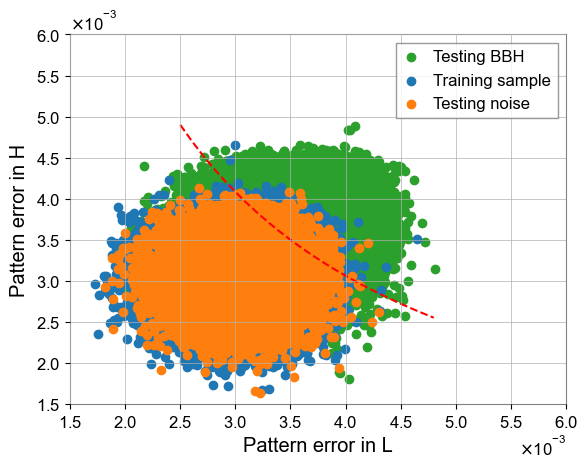

In [126]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.scatter(x = Feature_space_bbh[:,0],y = Feature_space_bbh[:,1], label = 'Testing BBH', color = colors[2])
plt.scatter(x = Feature_space_noise_train[:,0],y = Feature_space_noise_train[:,1], label = 'Training sample', color = colors[0])
plt.scatter(x = Feature_space_noise_test[:,0],y = Feature_space_noise_test[:,1], label = 'Testing noise', color = colors[1])
# plt.scatter(x = Feature_space_sg[:,0],y = Feature_space_sg[:,1])

x = np.arange(2.5e-3, 4.9e-3, 1e-4)
y = 12.25e-6/x

plt.plot(x,y,color = 'r',linestyle='dashed')
plt.xlim(1.5e-3, 6e-3)
plt.ylim(1.5e-3, 6e-3)
plt.xlabel('Pattern error in L')
plt.ylabel('Pattern error in H')
plt.legend()

In [116]:
x

array([0.0025])

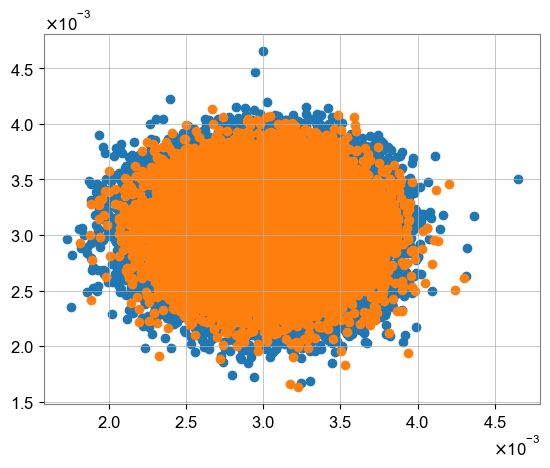

In [48]:
plt.scatter(x = Feature_space_noise_train[:,0],y = Feature_space_noise_train[:,1])
plt.scatter(x = Feature_space_noise_test[:,0],y = Feature_space_noise_test[:,1])
# plt.scatter(x = Feature_space_bbh[:,0],y = Feature_space_bbh[:,1])
# plt.scatter(x = Feature_space_sg[:,0],y = Feature_space_sg[:,1])

In [20]:
Geometric_mean_train = np.sqrt(Feature_space_noise_train[:,0] * Feature_space_noise_train[:,1])
Geometric_mean_test = np.sqrt(Feature_space_noise_test[:,0] * Feature_space_noise_test[:,1])
Geometric_mean_bbh = np.sqrt(Feature_space_bbh[:,0] * Feature_space_bbh[:,1])
Geometric_mean_sg = np.sqrt(Feature_space_sg[:,0] * Feature_space_sg[:,1])

In [23]:
Geometric_mean_bbh.shape

(100000,)

(array([  1.40604205,   3.65570934,  10.12350279,  25.5899654 ,
         51.60174341,  85.76856534, 142.99447697, 180.39519563,
        239.58956613, 299.62756187, 330.98229969, 384.97431459,
        434.18578651, 444.87170613, 468.63381685, 500.55097149,
        492.81774019, 496.61405374, 481.28819534, 451.19889537,
        420.26597017, 390.59848281, 325.77994409, 290.76949692,
        236.63687782, 218.49893531, 192.06534468, 194.17440776,
        195.86165823, 228.6224381 , 298.64333243, 362.0558291 ,
        448.10560285, 514.89260045, 565.51011442, 587.72557889,
        599.67693636, 544.70069201, 462.86904443, 395.09781739,
        326.62356932, 241.4174208 , 182.08244609, 128.3716396 ,
         89.9866915 ,  48.7896593 ,  27.83963268,  12.23256588,
          2.95268831,   0.70302103]),
 array([0.00095774, 0.00102887, 0.00109999, 0.00117111,
        0.00124223, 0.00131335, 0.00138447, 0.0014556 ,
        0.00152672, 0.00159784, 0.00166896, 0.00174008,
        0.0018112 , 0.0018

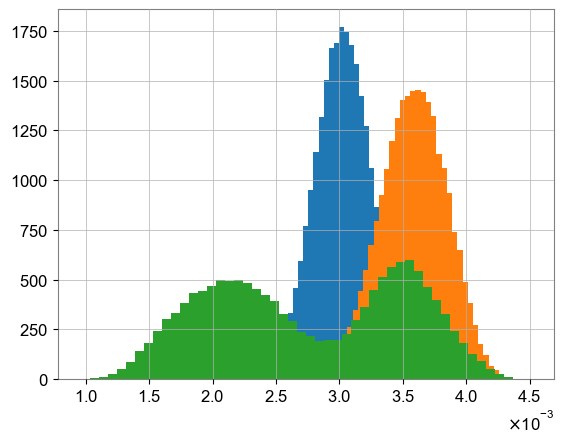

In [47]:
plt.hist(Geometric_mean_train,bins = 50, density=True)
plt.hist(Geometric_mean_bbh,bins = 50, density=True)
plt.hist(Geometric_mean_sg,bins = 50, density=True)

In [26]:
for threshold in np.arange(0,0.0045,0.0001):
    if np.argwhere(Geometric_mean_train > threshold).shape[0]/len(Geometric_mean_train) < 0.1:
        print(threshold-0.0001)
        break

0.0033000000000000004


In [29]:
np.argwhere(Geometric_mean_test > 0.0033).shape[0]/len(Geometric_mean_test)

0.11325

In [33]:
np.argwhere(Geometric_mean_test > 0.0033).shape

(2265, 1)

In [32]:
np.argwhere(Geometric_mean_bbh > 0.0033).shape

(85368, 1)

In [36]:
data_train = Feature_space_noise_train
data_signal_noise = Feature_space_noise_test[np.argwhere(Geometric_mean_test > 0.0033)].reshape(-1,2)
data_signal_bbh = Feature_space_bbh[np.argwhere(Geometric_mean_bbh > 0.0033)].reshape(-1,2)

## Training the model

In [15]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
# validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = VariationalAutoEncoder(4,2).cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        _,_,_,decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        # loss_norm = loss_func(decoded[:, -1], x[:, -1])
        
        weighted_lossTrain = loss_overall
        # weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    # autoencoder.eval()
    # with torch.no_grad():
    #     val_loss = 0
    #     for batchidx, (x, _) in enumerate(validationDataLoader):
    #         x = x.cuda()
    #         encoded, decoded = autoencoder(x)
    #         lossVal_overall = loss_func(decoded, x)
    #         lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
    #         lossVal = lossVal_overall + lossVal_norm * coef_delta
    #         val_loss += lossVal.item()

    #     val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    # loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f' % (epoch+1, weighted_lossTrain.item()))
    # print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.00960263
Epoch: 0002, Training loss=0.00213246
Epoch: 0003, Training loss=0.00003582
Epoch: 0004, Training loss=0.00011149
Epoch: 0005, Training loss=0.00000188
Epoch: 0006, Training loss=0.00000253
Epoch: 0007, Training loss=0.00000124
Epoch: 0008, Training loss=0.00000217
Epoch: 0009, Training loss=0.00000103
Epoch: 0010, Training loss=0.00000077
Epoch: 0011, Training loss=0.00000142
Epoch: 0012, Training loss=0.00000177
Epoch: 0013, Training loss=0.00000083
Epoch: 0014, Training loss=0.00000095
Epoch: 0015, Training loss=0.00000113
Epoch: 0016, Training loss=0.00000092
Epoch: 0017, Training loss=0.00000189
Epoch: 0018, Training loss=0.00000063
Epoch: 0019, Training loss=0.00000087
Epoch: 0020, Training loss=0.00000187
Epoch: 0021, Training loss=0.00000148
Epoch: 0022, Training loss=0.00000103
Epoch: 0023, Training loss=0.07115716
Epoch: 0024, Training loss=0.00000118
Epoch: 0025, Training loss=0.00000212
Epoch: 0026, Training loss=0.00000069
Epoch: 0027,

In [16]:
torch.save(autoencoder.cpu(), '../Model_cached/model_4_3_2_3_4_Error_space_GWAK_VAE.pt')

In [47]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
# validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = VariationalAutoEncoder(4,2).cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        _,_,_,decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, torch.zeros_like(decoded))
        # loss_norm = loss_func(decoded[:, -1], x[:, -1])
        
        weighted_lossTrain = loss_overall
        # weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    # autoencoder.eval()
    # with torch.no_grad():
    #     val_loss = 0
    #     for batchidx, (x, _) in enumerate(validationDataLoader):
    #         x = x.cuda()
    #         encoded, decoded = autoencoder(x)
    #         lossVal_overall = loss_func(decoded, x)
    #         lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
    #         lossVal = lossVal_overall + lossVal_norm * coef_delta
    #         val_loss += lossVal.item()

    #     val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    # loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f' % (epoch+1, weighted_lossTrain.item()))
    # print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.15665197
Epoch: 0002, Training loss=0.07878476
Epoch: 0003, Training loss=0.03741970
Epoch: 0004, Training loss=0.00673870
Epoch: 0005, Training loss=0.00194751
Epoch: 0006, Training loss=0.00059937
Epoch: 0007, Training loss=0.00018650
Epoch: 0008, Training loss=0.00005543
Epoch: 0009, Training loss=0.00003113
Epoch: 0010, Training loss=0.00001070
Epoch: 0011, Training loss=0.00000781
Epoch: 0012, Training loss=0.00000222
Epoch: 0013, Training loss=0.00000110
Epoch: 0014, Training loss=0.00000081
Epoch: 0015, Training loss=0.00000036
Epoch: 0016, Training loss=0.00000019
Epoch: 0017, Training loss=0.00000007
Epoch: 0018, Training loss=0.00000007
Epoch: 0019, Training loss=0.00000004
Epoch: 0020, Training loss=0.00000002
Epoch: 0021, Training loss=0.00000001
Epoch: 0022, Training loss=0.00000001
Epoch: 0023, Training loss=0.00000001
Epoch: 0024, Training loss=0.00000001
Epoch: 0025, Training loss=0.00000000
Epoch: 0026, Training loss=0.00000000
Epoch: 0027,

In [51]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
# validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = SupervisedModel().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, torch.zeros_like(decoded))
        # loss_norm = loss_func(decoded[:, -1], x[:, -1])
        
        weighted_lossTrain = loss_overall
        # weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    # autoencoder.eval()
    # with torch.no_grad():
    #     val_loss = 0
    #     for batchidx, (x, _) in enumerate(validationDataLoader):
    #         x = x.cuda()
    #         encoded, decoded = autoencoder(x)
    #         lossVal_overall = loss_func(decoded, x)
    #         lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
    #         lossVal = lossVal_overall + lossVal_norm * coef_delta
    #         val_loss += lossVal.item()

    #     val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    # loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f' % (epoch+1, weighted_lossTrain.item()))
    # print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.00000000
Epoch: 0002, Training loss=0.00000000
Epoch: 0003, Training loss=0.00000001
Epoch: 0004, Training loss=0.00000000
Epoch: 0005, Training loss=0.00000000
Epoch: 0006, Training loss=0.00000000
Epoch: 0007, Training loss=0.00000000
Epoch: 0008, Training loss=0.00000000
Epoch: 0009, Training loss=0.00000000
Epoch: 0010, Training loss=0.00000000
Epoch: 0011, Training loss=0.00000000
Epoch: 0012, Training loss=0.00000000
Epoch: 0013, Training loss=0.00000000
Epoch: 0014, Training loss=0.00000000
Epoch: 0015, Training loss=0.00000000
Epoch: 0016, Training loss=0.00000000
Epoch: 0017, Training loss=0.00000000
Epoch: 0018, Training loss=0.00000002
Epoch: 0019, Training loss=0.00000000
Epoch: 0020, Training loss=0.00000011
Epoch: 0021, Training loss=0.00000000
Epoch: 0022, Training loss=0.00000000
Epoch: 0023, Training loss=0.00000000
Epoch: 0024, Training loss=0.00000000
Epoch: 0025, Training loss=0.00000000
Epoch: 0026, Training loss=0.00000000
Epoch: 0027,

In [37]:
snr_list = np.arange(1,37,7)

In [62]:
snr_list = [15,22]

In [63]:
for i in range(len(snr_list)):
    
    data_signal = np.vstack((data_signal_noise, data_signal_bbh[np.random.choice(len(data_signal_bbh), size = int(snr_list[i] * len(data_signal_noise)))]))
    data_bkg = data_train[np.random.choice(len(data_train),size = min(len(data_signal),len(data_train)),  replace=False)]
    
    print(data_signal.shape)
    print(data_bkg.shape)
    
    data_signal_labeled = np.hstack((data_signal,np.ones(len(data_signal)).reshape(-1,1)))
    data_bkg_labeled = np.hstack((data_bkg,np.zeros(len(data_bkg)).reshape(-1,1)))
    
    Final_training_and_validation_set = np.vstack((data_signal_labeled, data_bkg_labeled))
    np.random.shuffle(Final_training_and_validation_set)

    trainData = torch.FloatTensor(Final_training_and_validation_set[:int(0.9 * len(Final_training_and_validation_set))])
    validationData = torch.FloatTensor(Final_training_and_validation_set[int(0.9 * len(Final_training_and_validation_set)):])
    train_dataset = TensorDataset(trainData, trainData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


    autoencoder = SupervisedModel().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.BCELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))


    for epoch in range(epochs):
        # 训练阶段
        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            decoded = autoencoder(x[:,:2])
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded.flatten(), x[:,-1])
            # loss_norm = loss_func(decoded[:, -1], x[:, -1])
            
            weighted_lossTrain = loss_overall
            # weighted_lossTrain = loss_overall + loss_norm * coef_delta
            
            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term
            
            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        # 验证阶段
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                decoded = autoencoder(x[:,:2])
                lossVal_overall = loss_func(decoded.flatten(), x[:,-1])
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * coef_delta
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)
        
        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
        # print('Epoch: %04d, Training loss=%.8f' % (epoch+1, weighted_lossTrain.item()))
        print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))
        
    torch.save(autoencoder.cpu(),'../Model_cached/model_weakly_supervised_2-8-6-4-1_GWAK_snr'+str(snr_list[i])+'_new_new.pt')
    
    
    fig = plt.figure(figsize=(6, 3))
    ax = plt.subplot(1, 1, 1)
    ax.grid()
    ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
    ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
    ax.set_xlabel('Epoches')
    ax.set_ylabel('Loss')
    ax.set_title('Trainging loss, weakly supervised learning model, 0.1 anomaly cut, snr' +str(snr_list[i]))
    plt.ylim(0,1)
    plt.legend()
    # plt.show()
    plt.savefig('../Pic_cached/Trainging loss, weakly supervised learning model, 0.1 anomaly cut, snr'+str(snr_list[i])+'_new_new,2-8-6-4-1.png')

(36240, 2)
(36240, 2)
Epoch: 0001, Training loss=0.68746459, Validation loss=0.69340190
Epoch: 0002, Training loss=0.69318187, Validation loss=0.69316424
Epoch: 0003, Training loss=0.69363391, Validation loss=0.69314058
Epoch: 0004, Training loss=0.69329357, Validation loss=0.69313266
Epoch: 0005, Training loss=0.69325936, Validation loss=0.69312845
Epoch: 0006, Training loss=0.69303775, Validation loss=0.69312707
Epoch: 0007, Training loss=0.69312692, Validation loss=0.69312580
Epoch: 0008, Training loss=0.69335115, Validation loss=0.69312374
Epoch: 0009, Training loss=0.69302297, Validation loss=0.69312150
Epoch: 0010, Training loss=0.69308823, Validation loss=0.69311788
Epoch: 0011, Training loss=0.69302154, Validation loss=0.69311503
Epoch: 0012, Training loss=0.69305301, Validation loss=0.69311299
Epoch: 0013, Training loss=0.69307423, Validation loss=0.69311054
Epoch: 0014, Training loss=0.69310683, Validation loss=0.69310703
Epoch: 0015, Training loss=0.69274306, Validation loss

In [53]:
torch.save(autoencoder.cpu(),'../Model_cached/model_supervised_4-64-32-1_GWAK_error_space.pt')

In [77]:
autoencoder = torch.load('../Model_cached/model_4_3_2_3_4_Error_Space_GWAK.pt')

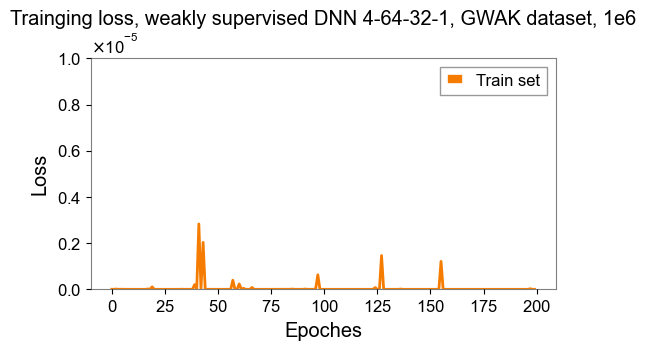

In [54]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
# ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, weakly supervised DNN 4-64-32-1, GWAK dataset, 1e6')
plt.ylim(0,0.00001)
plt.legend()
plt.show()

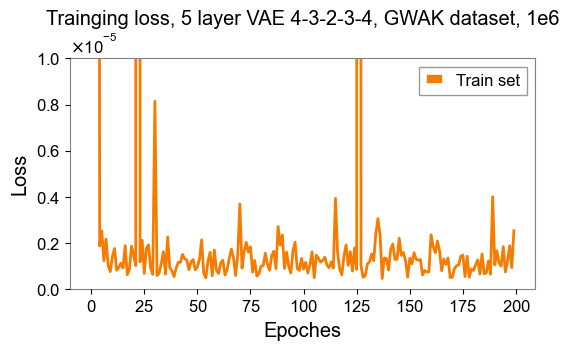

In [17]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
# ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer VAE 4-3-2-3-4, GWAK dataset, 1e6')
plt.ylim(0,0.00001)
plt.legend()
plt.show()

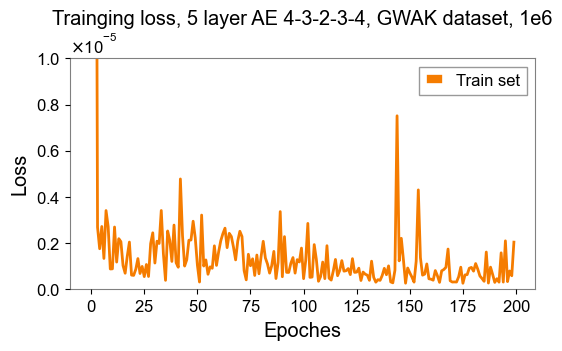

In [25]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
# ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer AE 4-3-2-3-4, GWAK dataset, 1e6')
plt.ylim(0,0.00001)
plt.legend()
plt.show()

In [91]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData_train)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

In [92]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData_test)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

In [93]:
_, decodedTestdata = autoencoder(bbhData)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((bbhData - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [94]:
data_sinegaussian_tensored = sgData
_, decodedTestdata = autoencoder(data_sinegaussian_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_sinegaussian = decodedTestdata.detach().numpy()
ReconstructedError_sinegaussian = torch.mean((data_sinegaussian_tensored - reconstructedData_sinegaussian)**2,dim=1)
MSE_sinegaussian = ReconstructedError_sinegaussian.mean()

### Reconstruction procedure for weakly supervised model

In [86]:
decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData_train)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

AttributeError: 'tuple' object has no attribute 'double'

In [87]:
decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData_test)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

AttributeError: 'tuple' object has no attribute 'double'

In [88]:
decodedTestdata = autoencoder(bbhData)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((bbhData - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

AttributeError: 'tuple' object has no attribute 'double'

In [60]:
data_sinegaussian_tensored = sgData
decodedTestdata = autoencoder(data_sinegaussian_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_sinegaussian = decodedTestdata.detach().numpy()
ReconstructedError_sinegaussian = torch.mean((data_sinegaussian_tensored - reconstructedData_sinegaussian)**2,dim=1)
MSE_sinegaussian = ReconstructedError_sinegaussian.mean()

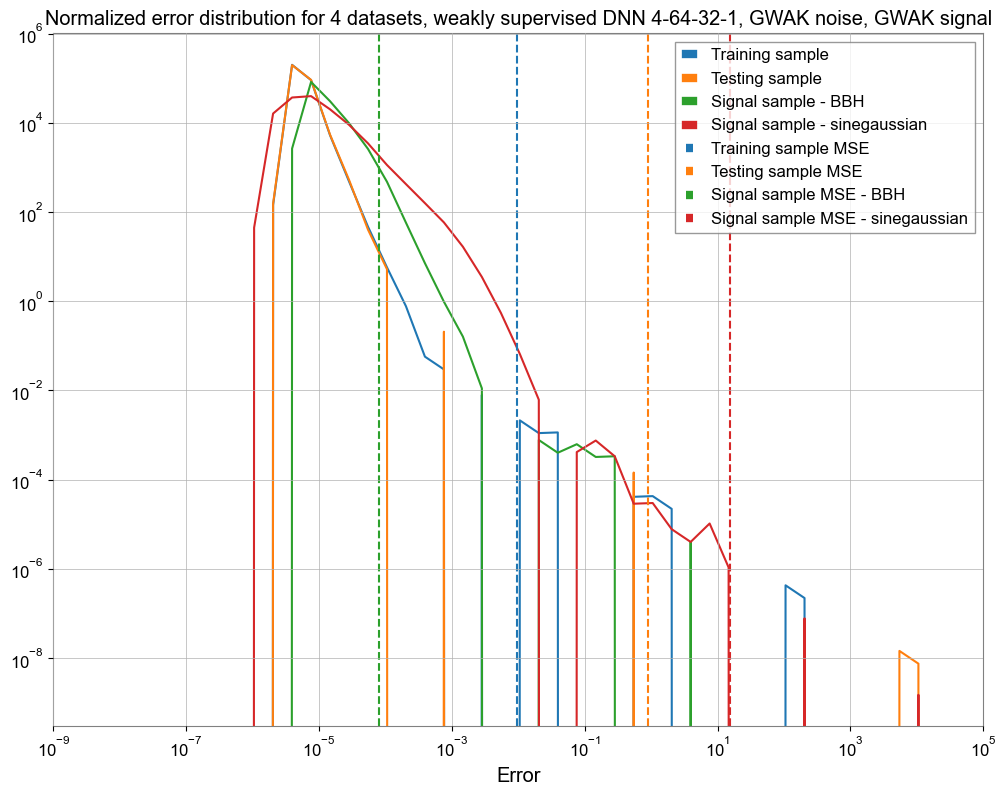

In [61]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.logspace(-9,5,50)

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

plt.axvline(x = MSE_sinegaussian, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(1e-9, 1e5)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 4 datasets, weakly supervised DNN 4-64-32-1, GWAK noise, GWAK signal')
plt.legend()
plt.show()

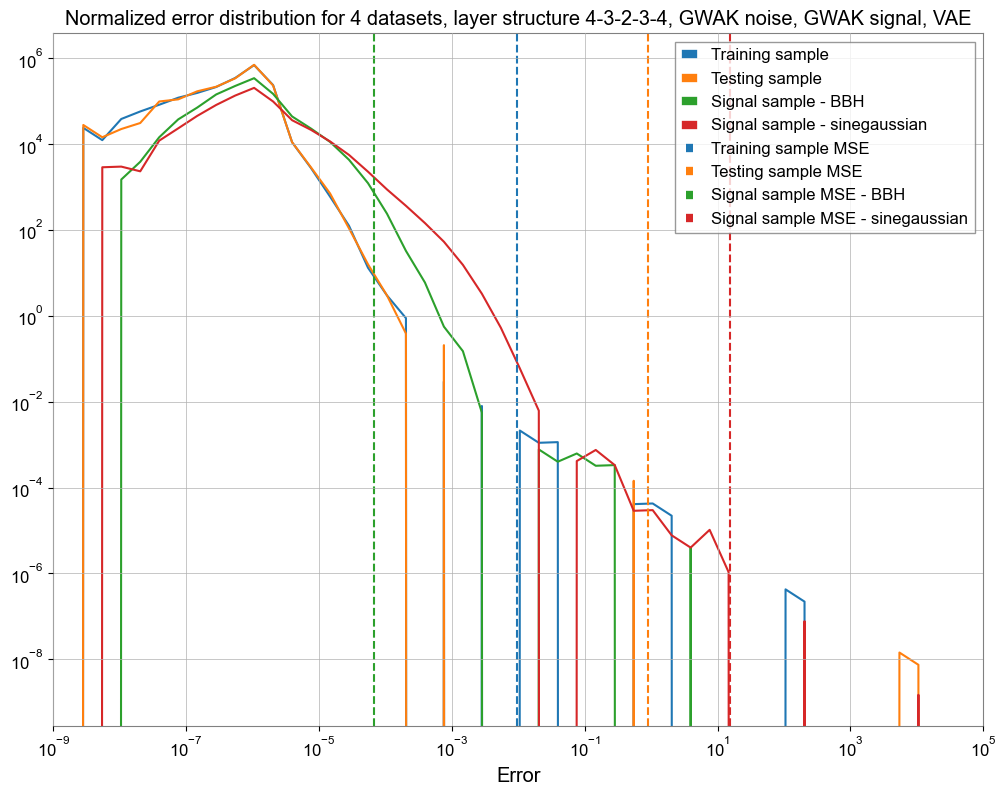

In [25]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.logspace(-9,5,50)

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

plt.axvline(x = MSE_sinegaussian, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(1e-9, 1e5)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 4 datasets, layer structure 4-3-2-3-4, GWAK noise, GWAK signal, VAE')
plt.legend()
plt.show()

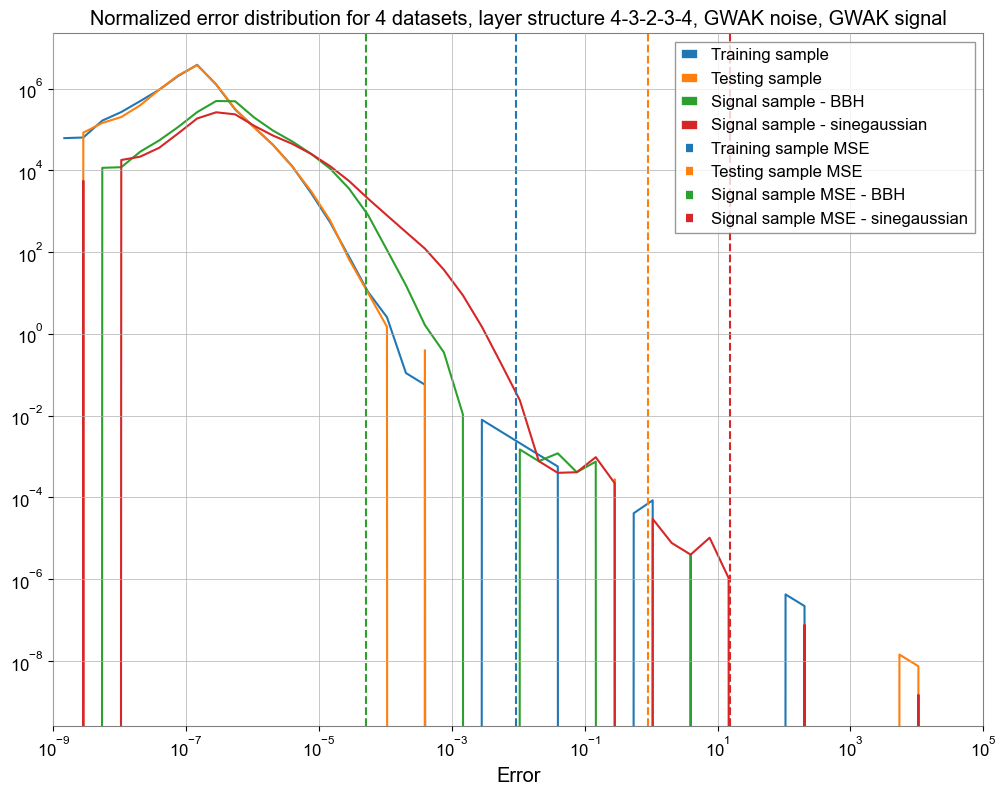

In [30]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.logspace(-9,5,50)

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

plt.axvline(x = MSE_sinegaussian, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(1e-9, 1e5)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 4 datasets, layer structure 4-3-2-3-4, GWAK noise, GWAK signal')
plt.legend()
plt.show()

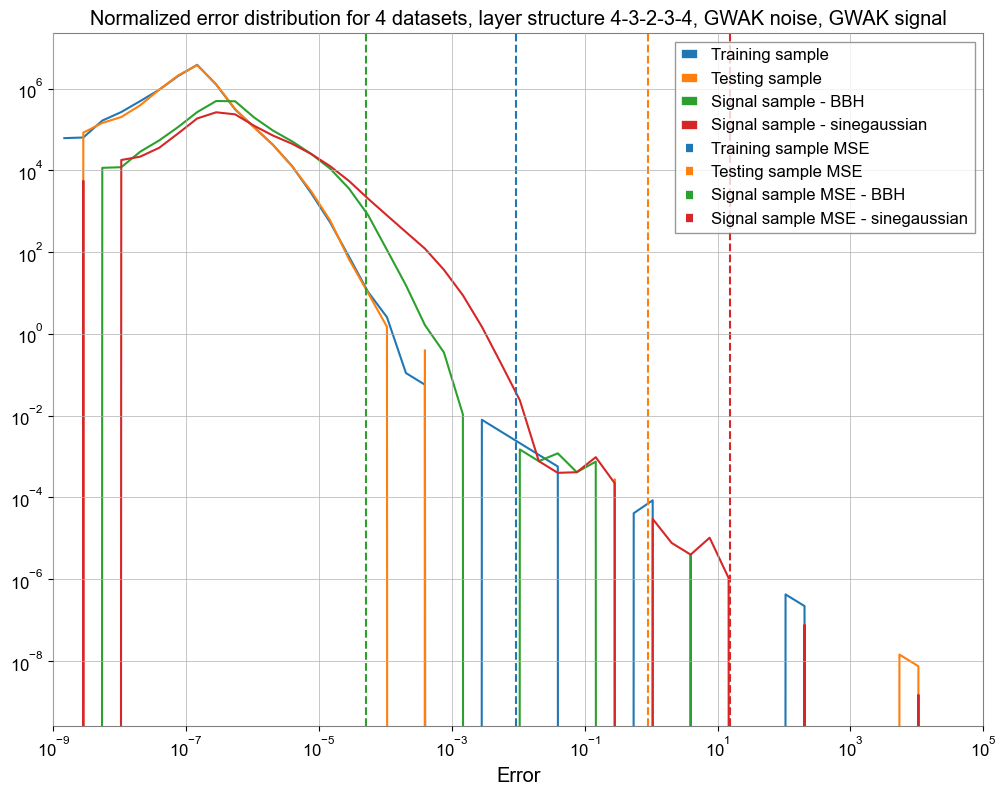

In [95]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.logspace(-9,5,50)

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

plt.axvline(x = MSE_sinegaussian, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(1e-9, 1e5)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 4 datasets, layer structure 4-3-2-3-4, GWAK noise, GWAK signal')
plt.legend()
plt.show()

In [128]:
def upperTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        threshold = np.sort(trainerror)[-index_number]
            
        # print(threshold)
        # print(np.argwhere(signalerror > threshold).shape)
        TPRlist[i] = np.argwhere(signalerror > threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

def lowerTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        if index_number == 0:
            threshold = np.sort(trainerror)[index_number]
        else:
            threshold = np.sort(trainerror)[index_number-1]
        # print(np.sort(trainerror))
        # print(threshold)
        # print(np.argwhere(signalerror < threshold).shape)
        TPRlist[i] = np.argwhere(signalerror < threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

FPR_list = np.logspace(-3,0,30)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

In [101]:
TPR_list_test = upperTPRFPRcalc(ReconstructedError_train.flatten(), ReconstructedError_test.flatten(), FPR_list)
TPR_list_BBH = upperTPRFPRcalc(ReconstructedError_train.flatten(), ReconstructedError_injected.flatten(), FPR_list)
TPR_list_SG = lowerTPRFPRcalc(ReconstructedError_train.flatten(), ReconstructedError_sinegaussian.flatten(), FPR_list)
# TPR_list_real_glitches = upperTPRFPRcalc(ReconstructedError_train_output_200d.flatten(), ReconstructedError_glitch_output_200d.flatten(), FPR_list)
# TPR_list_fake_glitches = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_fake_output_100d.flatten(), FPR_list)

In [129]:
TPR_list_test = upperTPRFPRcalc(Geometric_mean_train.flatten(), Geometric_mean_test.flatten(), FPR_list)
TPR_list_BBH = upperTPRFPRcalc(Geometric_mean_train.flatten(), Geometric_mean_bbh.flatten(), FPR_list)
# TPR_list_SG = lowerTPRFPRcalc(ReconstructedError_train.flatten(), ReconstructedError_sinegaussian.flatten(), FPR_list)
# TPR_list_real_glitches = upperTPRFPRcalc(ReconstructedError_train_output_200d.flatten(), ReconstructedError_glitch_output_200d.flatten(), FPR_list)
# TPR_list_fake_glitches = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_fake_output_100d.flatten(), FPR_list)

In [52]:
from sklearn.metrics import auc

Text(0.5, 1.0, 'Pattern ROC curve, 4D error space, GWAK set')

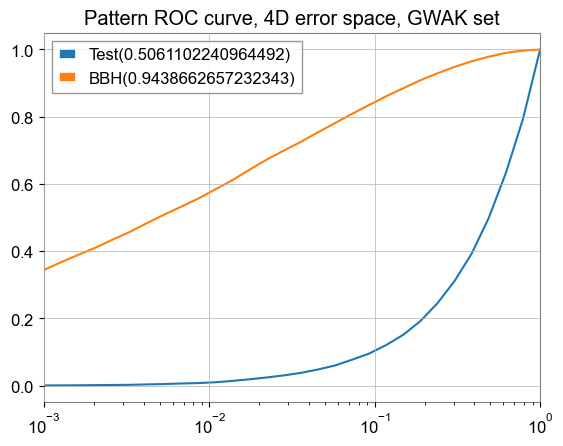

In [60]:
plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test(' + str(auc(FPR_list, TPR_list_test)) + ")")
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH(' + str(auc(FPR_list, TPR_list_BBH)) + ")")
# plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG(' + str(auc(FPR_list, TPR_list_SG)) + ")")
# plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'Glitches(' + str(auc(FPR_list, TPR_list_real_glitches)) + ")")
# plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('Pattern ROC curve, 4D error space, GWAK set')

In [53]:
plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test(' + str(auc(FPR_list, TPR_list_test)) + ")")
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH(' + str(auc(FPR_list, TPR_list_BBH)) + ")")
# plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG(' + str(auc(FPR_list, TPR_list_SG)) + ")")
# plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'Glitches(' + str(auc(FPR_list, TPR_list_real_glitches)) + ")")
# plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('Pattern ROC curve, 4D error space, GWAK set')

NameError: name 'colors' is not defined

## Plotting work

In [32]:
(Reconstruction_error_L['noise_train_pattern'] * Reconstruction_error_H['noise_train_pattern']).shape

(70000,)

(0.0, 0.01)

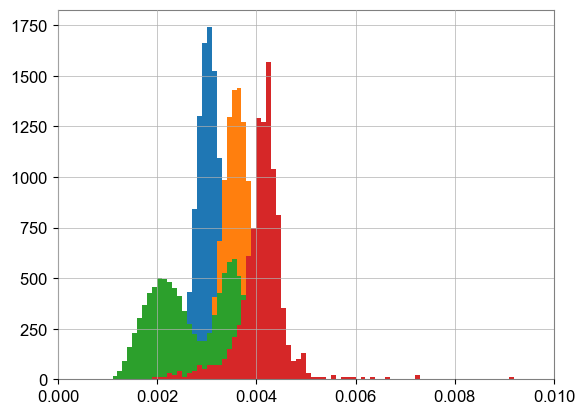

In [48]:
plt.hist(np.sqrt(Reconstruction_error_L['noise_train_pattern'] * Reconstruction_error_H['noise_train_pattern']), bins=np.arange(0,1e-2,1e-4), density=True)
plt.hist(np.sqrt(Reconstruction_error_L['bbh_pattern'] * Reconstruction_error_H['bbh_pattern']), bins=np.arange(0,1e-2,1e-4), density=True)
plt.hist(np.sqrt(Reconstruction_error_L['sg_pattern'] * Reconstruction_error_H['sg_pattern']), bins=np.arange(0,1e-2,1e-4), density=True)
plt.hist(np.sqrt(Reconstruction_error_L['glitch_pattern'] * Reconstruction_error_H['glitch_pattern']), bins=np.arange(0,1e-2,1e-4), density=True)
plt.xlim(0,1e-2)

(array([7.400e+01, 5.020e+02, 1.493e+03, 2.572e+03, 3.487e+03,
        4.057e+03, 4.479e+03, 4.579e+03, 4.732e+03, 4.494e+03,
        4.217e+03, 3.932e+03, 3.417e+03, 3.058e+03, 2.479e+03,
        2.109e+03, 1.676e+03, 1.494e+03, 1.290e+03, 1.314e+03,
        1.251e+03, 1.456e+03, 1.738e+03, 2.037e+03, 2.432e+03,
        2.838e+03, 3.034e+03, 3.204e+03, 3.281e+03, 3.275e+03,
        3.270e+03, 2.858e+03, 2.500e+03, 2.302e+03, 1.903e+03,
        1.665e+03, 1.291e+03, 1.094e+03, 8.390e+02, 6.930e+02,
        4.830e+02, 4.140e+02, 2.770e+02, 1.560e+02, 1.260e+02,
        6.400e+01, 3.900e+01, 1.400e+01, 9.000e+00, 2.000e+00]),
 array([9.17273164e-07, 1.30642006e-06, 1.69556695e-06,
        2.08471384e-06, 2.47386074e-06, 2.86300763e-06,
        3.25215453e-06, 3.64130142e-06, 4.03044831e-06,
        4.41959521e-06, 4.80874210e-06, 5.19788899e-06,
        5.58703589e-06, 5.97618278e-06, 6.36532967e-06,
        6.75447657e-06, 7.14362346e-06, 7.53277035e-06,
        7.92191725e-06, 8.311064

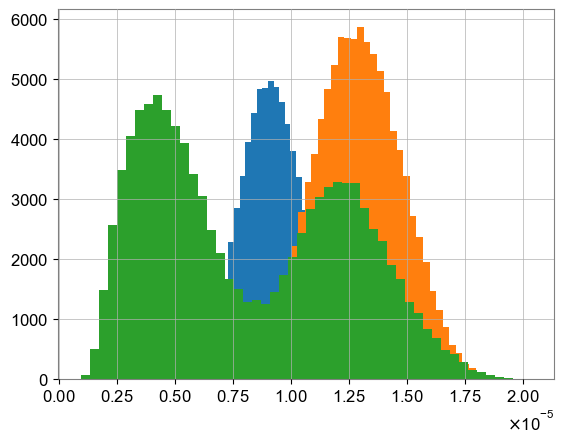

In [36]:
plt.hist(Reconstruction_error_L['noise_train_pattern'] * Reconstruction_error_H['noise_train_pattern'], bins=50)
plt.hist(Reconstruction_error_L['bbh_pattern'] * Reconstruction_error_H['bbh_pattern'], bins=50)
plt.hist(Reconstruction_error_L['sg_pattern'] * Reconstruction_error_H['sg_pattern'], bins=50)
plt.hist(Reconstruction_error_L['glitch_pattern'] * Reconstruction_error_H['glitch_pattern'], bins=50)

### ROC analysis

In [40]:
def upperTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        threshold = np.sort(trainerror)[-index_number]
            
        # print(threshold)
        # print(np.argwhere(signalerror > threshold).shape)
        TPRlist[i] = np.argwhere(signalerror > threshold).shape[1] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

def lowerTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        if index_number == 0:
            threshold = np.sort(trainerror)[index_number]
        else:
            threshold = np.sort(trainerror)[index_number-1]
        # print(np.sort(trainerror))
        # print(threshold)
        # print(np.argwhere(signalerror < threshold).shape)
        TPRlist[i] = np.argwhere(signalerror < threshold).shape[1] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

In [41]:
FPR_list = np.logspace(-3,0,30)

In [42]:
TPR_list_test = upperTPRFPRcalc(ReconstructedError_train.flatten(), ReconstructedError_test.flatten(), FPR_list)
TPR_list_BBH = upperTPRFPRcalc(ReconstructedError_train.flatten(), ReconstructedError_injected.flatten(), FPR_list)
TPR_list_SG = upperTPRFPRcalc(ReconstructedError_train.flatten(), ReconstructedError_sinegaussian.flatten(), FPR_list)
# TPR_list_real_glitches = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_real_output_100d.flatten(), FPR_list)
# TPR_list_fake_glitches = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_fake_output_100d.flatten(), FPR_list)

Text(0.5, 1.0, 'Pattern ROC curve, network structure VAE 4-3-2-3-4, full GWAK set')

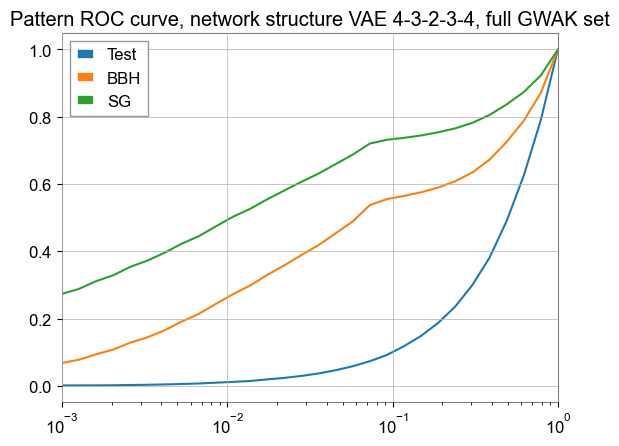

In [43]:
plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
# plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
# plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('Pattern ROC curve, network structure VAE 4-3-2-3-4, full GWAK set')

In [136]:
TPR_list_for_plot = TPR_list_for_plot.reshape(-1,30)

In [137]:
alpha_list = np.arange(1/8,9/8,1/8)

In [139]:
snr_list.shape

(6,)

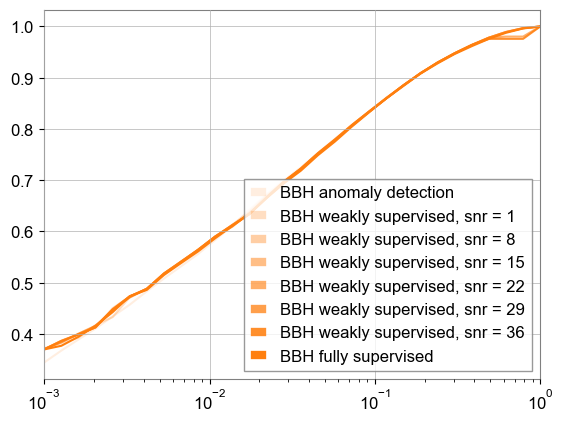

In [140]:
for i in range(len(TPR_list_for_plot)):
    # plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
    if i == 0:
        plt.plot(FPR_list, TPR_list_for_plot[i], color = colors[1], alpha = alpha_list[i],label = 'BBH anomaly detection')
    elif i == 7:
        plt.plot(FPR_list, TPR_list_for_plot[i], color = colors[1], alpha = alpha_list[i],label = 'BBH fully supervised')
    else:
        plt.plot(FPR_list, TPR_list_for_plot[i], color = colors[1], alpha = alpha_list[i],label = 'BBH weakly supervised, snr = '+str(snr_list[i-1]))
# plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
# plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
# plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
# plt.title('')

## Study the SVM method

### First, standarize the data. Lets do that for the training sample

In [8]:
mu = np.mean(Reconstruction_error_noise, axis=0)
sig = np.std(Reconstruction_error_glitch, axis=0)
X_noise = (Reconstruction_error_noise - mu)/sig
X_glitch = (Reconstruction_error_glitch - mu)/sig
X_bbh = (Reconstruction_error_bbh - mu)/sig
X_sg = (Reconstruction_error_sg - mu)/sig